In [1]:
import numpy as np
from numpy import random as rnd
from matplotlib import pyplot as plt
import warnings,os,time,datetime

import torch

from scipy.interpolate import pchip
from keras.datasets import cifar10

C:\Users\Jan\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
class DISTRIBUTION():
    def __init__(self,datapoints):
        self.datapoints = datapoints
        self.__build_interpolate()
        return
    def __build_interpolate(self):
        x0 = np.array(self.datapoints)[:,0]
        y0 = np.array(self.datapoints)[:,1]
        f = pchip(x0,y0)
        self.x = np.arange(np.min(x0),np.max(x0))
        yp = f(self.x)
        self.p = yp/yp.sum()
        return
    def plot_distribution(self):
        plt.plot(self.x,self.p)
        plt.xlabel('x')
        plt.ylabel('Pr(X=x)')
        plt.title('Probability Density')
        plt.show() 
        return self.x,self.p
    def sample(self,n=1):
        return rnd.choice(self.x,p=self.p,size=n)

In [3]:
class WORLD_DISTRIBUTION():
    def __init__(self,datapoints):
        self.pdf = DISTRIBUTION(datapoints)
        self.datapoints = [None]*self.pdf.x.shape[0]
        self.__assign_random_datavectors()
        return
    def __assign_random_datavectors(self):
        (x_train,y_train),_ = cifar10.load_data()
        self.datapoints = x_train[rnd.permutation(np.arange(0,x_train.shape[0]))[:self.pdf.x.shape[0]],:,:,:]
        return
    def sample(self,n=1):
        return self.datapoints[[int(self.pdf.sample(n)[k]) for k in range(n)],:,:,:]
    def plot_distribution(self):
        self.pdf.plot_distribution()
        return

In [4]:
datapoints = [
    [0,0],
    [2,1],
    [4,1.4],
    [14,0.3],
    [23,2],
    [26,1],
    [40,0],
]

In [5]:
w_distr = WORLD_DISTRIBUTION(datapoints)

In [220]:
#class PrebrainCompressor(torch.nn.Module):
#    def __init__(self):
#        super(PrebrainCompressor,self).__init__()
#        self.layer0 = torch.nn.Sequential(
#            torch.nn.Conv2d(
#                in_channels = 3,
#                out_channels = 16,
#                kernel_size = 5,
#                stride = 1,
#                padding = 0
#            ),
#            torch.nn.BatchNorm2d(16),
#            torch.nn.ReLU(),
#            torch.nn.MaxPool2d(kernel_size=(2,2),stride=(2,2))
#        )
#        self.layer1 = torch.nn.Sequential(
#            torch.nn.Conv2d(
#                in_channels = 16,
#                out_channels = 32,
#                kernel_size = 5,
#                stride = 1,
#                padding = 0
#            ),
#            torch.nn.BatchNorm2d(32),
#            torch.nn.ReLU(),
#            torch.nn.MaxPool2d(kernel_size=(2,2),stride=(2,2))
#        )
#        self.layer2 = torch.nn.Sigmoid()
#    def forward(self,x):
#        out = self.layer0(x)
#        out = self.layer1(out)
#        out = out.reshape(out.size(0)*out.size(1)*out.size(2)*out.size(3),-1)
#        out = self.layer2(out)
#        return out

class PrebrainCompressor(torch.nn.Module):
    def __init__(self):
        super(PrebrainCompressor,self).__init__()
        self.comp_layer0 = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels = 3,
                out_channels = 16,
                kernel_size = 5,
                stride = 1,
                padding = 0
            ),
            torch.nn.BatchNorm2d(16),
            torch.nn.Tanh(),
            torch.nn.MaxPool2d(kernel_size=(2,2),stride=(2,2))
        )
        self.comp_layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels = 16,
                out_channels = 32,
                kernel_size = 5,
                stride = 1,
                padding = 0
            ),
            torch.nn.BatchNorm2d(32),
            torch.nn.Tanh(),
            torch.nn.MaxPool2d(kernel_size=(2,2),stride=(2,2))
        )
        self.enc = torch.nn.Sigmoid()
        self.decomp_layer0 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(
                in_channels = 32,
                out_channels = 16,
                kernel_size = 13,
                stride = 1,
                padding = 0
            ),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU()
        )
        self.decomp_layer1 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(
                in_channels = 16,
                out_channels = 3,
                kernel_size = 16,
                stride = 1,
                padding = 0
            ),
            torch.nn.BatchNorm2d(3),
            torch.nn.ReLU()
        )
        self.dec = torch.nn.Sigmoid()
    def forward(self,x):
        x = self.comp_layer0(x)
        x = self.comp_layer1(x)
        o_size = x.size()
        x = x.reshape(o_size[0]*o_size[1]*o_size[2]*o_size[3],-1)
        x = self.enc(x)
        x = x.reshape(o_size)
        x = self.decomp_layer0(x)
        x = self.decomp_layer1(x)
        x = self.dec(x)
        return x
    def encode(self,x):
        x = self.comp_layer0(x)
        x = self.comp_layer1(x)
        o_size = x.size()
        x = x.reshape(o_size[0]*o_size[1]*o_size[2]*o_size[3],-1)
        x = self.enc(x)
        return x
    def decode(self,x):
        x = self.decomp_layer0(x)
        x = self.decomp_layer1(x)
        x = self.dec(x)
        return x

In [285]:
NUM_BATCHES = 1000
SAMPLES_PER_BATCH = 5

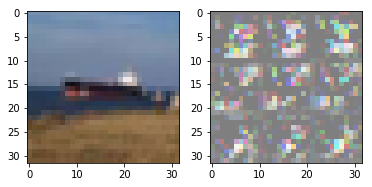

Processing batch 0/1000


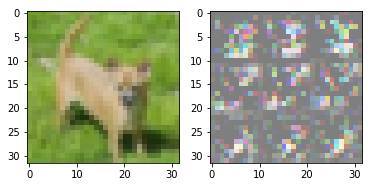

Processing batch 100/1000


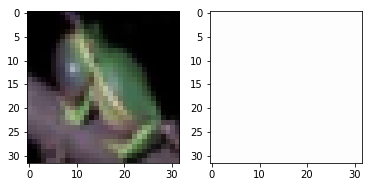

Processing batch 200/1000


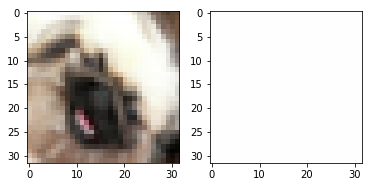

Processing batch 300/1000


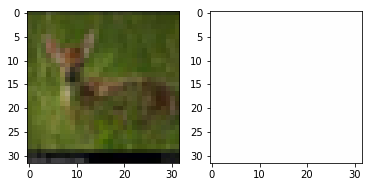

Processing batch 400/1000


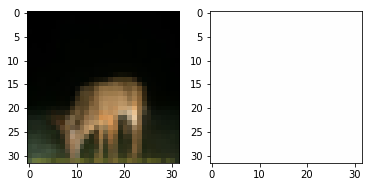

Processing batch 500/1000


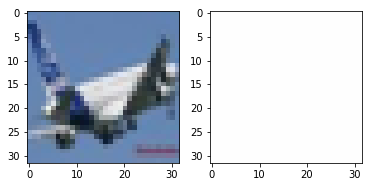

Processing batch 600/1000


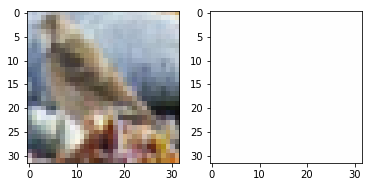

Processing batch 700/1000


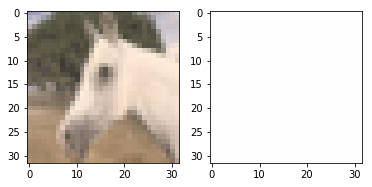

Processing batch 800/1000


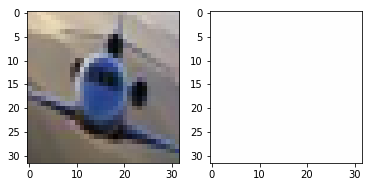

Processing batch 900/1000


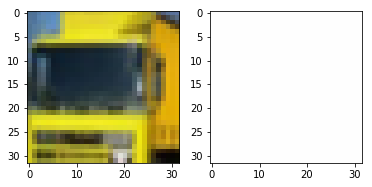

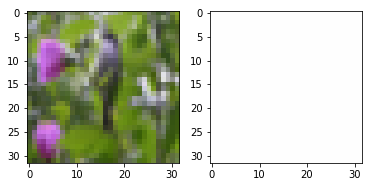

In [286]:
comp = PrebrainCompressor()

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(comp.parameters(), lr=0.1)

print('Initial performance:\n')
fig,ax = plt.subplots(ncols=2,nrows=1)
c_inp = w_distr.sample()[0]
c_out = comp.forward(x=torch.Tensor(c_inp.reshape(-1,3,32,32))).detach().numpy().reshape(-1,32,32,3)
ax[0].imshow(c_inp)
ax[1].imshow(c_out[0])
plt.show()

inputs_list = []
outputs_list = []
losses = []

for batch_ctr in range(NUM_BATCHES):
    
    if batch_ctr%int('1'+'0'*int(np.log10(NUM_BATCHES)-1))==0: 
        print('Processing batch {}/{}, example output:'.format(batch_ctr,NUM_BATCHES))
        
        fig,ax = plt.subplots(ncols=2,nrows=1)
        c_inp = w_distr.sample()[0]
        c_out = comp.forward(x=torch.Tensor(c_inp.reshape(-1,3,32,32))).detach().numpy().reshape(-1,32,32,3)
        ax[0].imshow(c_inp)
        ax[1].imshow(c_out[0])
        plt.show()
    
    c_batch = w_distr.sample(SAMPLES_PER_BATCH)
    inputs_list.append(c_batch)
    
    c_outputs = comp.forward(x=torch.Tensor(c_batch.reshape(-1,3,32,32)))
    outputs_list.append(c_outputs.detach().numpy().reshape(SAMPLES_PER_BATCH,32,32,3))
    
    loss = criterion(c_outputs,torch.Tensor(c_batch).reshape(-1,3,32,32))
    losses.append(loss.detach().numpy())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
inputs_list = np.stack(inputs_list,axis=0)
outputs_list = np.stack(outputs_list,axis=0)
losses = np.stack(losses,axis=0)

print('\nFinal performance:\n')
fig,ax = plt.subplots(ncols=2,nrows=1)
c_inp = w_distr.sample()[0]
c_out = comp.forward(x=torch.Tensor(c_inp.reshape(-1,3,32,32))).detach().numpy().reshape(-1,32,32,3)
ax[0].imshow(c_inp)
ax[1].imshow(c_out[0])
plt.show()